In [1]:
# Import Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Display Pandas Outputs
pd.set_option('display.max_columns', 50)

In [2]:
orders = pd.read_csv("../data/orders.csv")
order_products = pd.read_csv("../data/order_products__prior.csv")
products = pd.read_csv("../data/products.csv")
aisles = pd.read_csv("../data/aisles.csv")
departments = pd.read_csv("../data/departments.csv")


In [3]:
print(orders.shape, orders.columns)
print(order_products.shape, order_products.columns)

(3421083, 7) Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')
(32434489, 4) Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')


In [4]:
# Orders per customer
orders_per_user = orders.groupby("user_id")["order_id"].count()
print("Orders per user statistics:")
print(orders_per_user.describe())
print("\n")

# Products per order
products_per_order = order_products.groupby("order_id")["product_id"].count()
print("Products per order statistics:")
print(products_per_order.describe())

Orders per user statistics:
count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_id, dtype: float64


Products per order statistics:
count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: product_id, dtype: float64


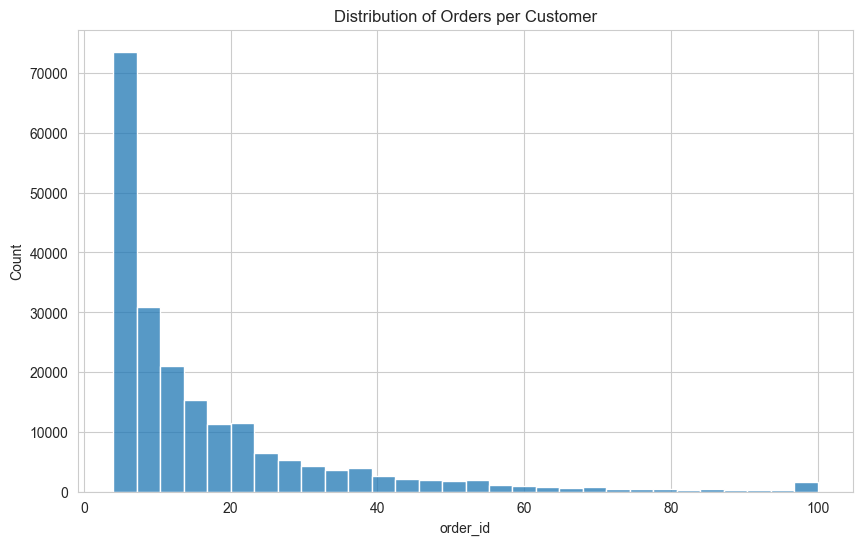

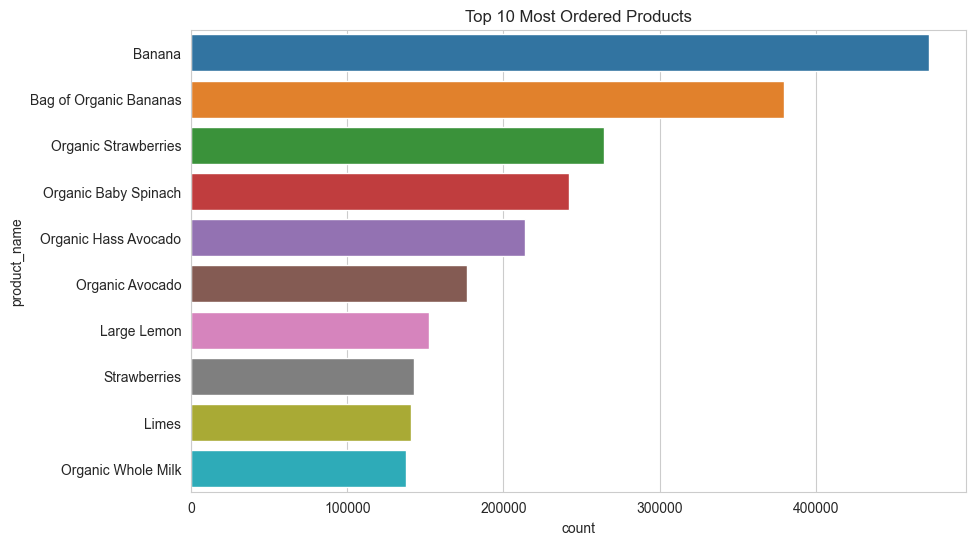

Overall reorder ratio: 0.59


In [12]:
# Orders per customer distribution
sns.histplot(orders_per_user, bins=30, kde=False)
plt.title("Distribution of Orders per Customer")
plt.show()

# Top products
top_products = (
    order_products["product_id"]
    .value_counts()
    .head(10)
    .rename_axis("product_id")
    .reset_index(name="count")
    .merge(products, on="product_id")
)
sns.barplot(data=top_products, x="count", y="product_name")
plt.title("Top 10 Most Ordered Products")
plt.show()

# Reorder ratio
reorder_ratio = order_products["reordered"].mean()
print(f"Overall reorder ratio: {reorder_ratio:.2f}")


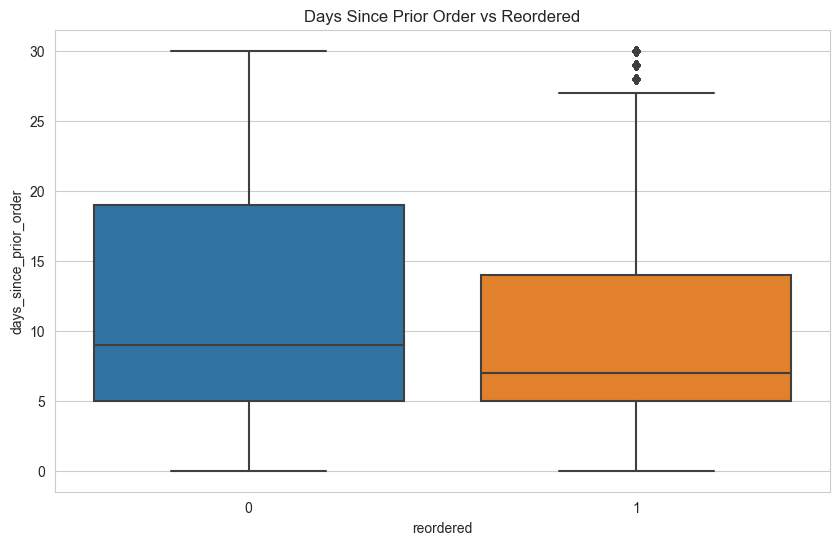

In [19]:
# Merge reordered flag from order_products with order info
merged_df = order_products.merge(
    orders[['order_id', 'order_number', 'days_since_prior_order']],
    on='order_id',
    how='left'
)


sns.boxplot(data=merged_df, x='reordered', y='days_since_prior_order')
plt.title("Days Since Prior Order vs Reordered")
plt.show()

### ⏳ Reorder Timing Insight

- The boxplot above shows the relationship between **days since prior order** and whether a product was **reordered**.
- Customers are **more likely to reorder** when the previous purchase happened recently.
- Most reorders occur within **7–10 days**, suggesting strong short-term brand or product loyalty.
- As the gap since the last order increases, the likelihood of reorder drops significantly.


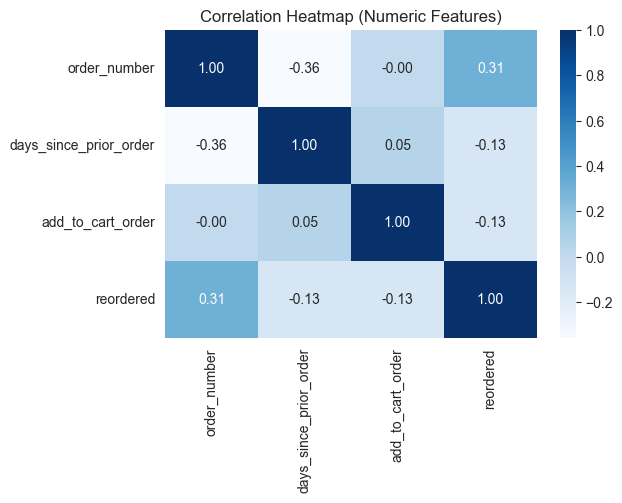

In [20]:
numeric_cols = ['order_number', 'days_since_prior_order', 'add_to_cart_order', 'reordered']
corr = merged_df[numeric_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


### 🔍 Correlation Insights

- Most numeric features show **weak or no strong linear correlation**, with the highest being only **-0.36** between `days_since_prior_order` and `reordered`.
- This negative relationship indicates that **recent purchases** are slightly more likely to be reordered — but overall, behavior is **complex and non-linear**.
- Such low correlations are typical in **customer behavior data**, where multiple factors (day of week, product type, order context) interact in non-linear ways.
- This insight supports the decision to use **machine learning models** (like logistic regression or tree-based models) instead of relying on simple correlation-driven heuristics.


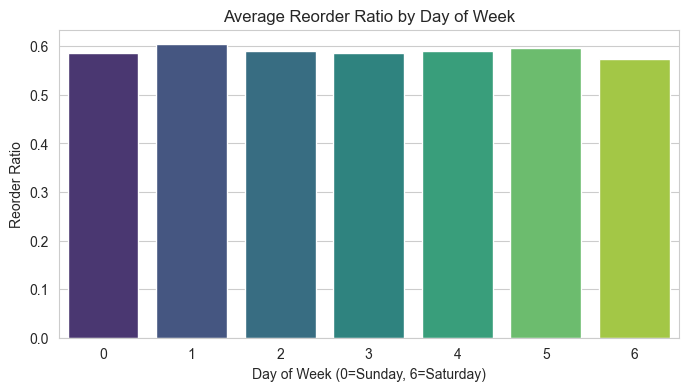

In [25]:
# Merge reorder flag with order day info
order_products_merged= order_products.merge(
    orders[['order_id', 'order_dow']], on='order_id', how='left'
)

# Compute reorder ratio per day of week
reorder_by_dow = (
    order_products_merged.groupby('order_dow')['reordered']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,4))
sns.barplot(data=reorder_by_dow, x='order_dow', y='reordered', palette='viridis')
plt.title("Average Reorder Ratio by Day of Week")
plt.xlabel("Day of Week (0=Sunday, 6=Saturday)")
plt.ylabel("Reorder Ratio")
plt.show()


### 📅 Weekly Reordering Patterns
- Reorders peak on **Mondays** at around 60%, aligning with typical grocery restocks.
- Midweek shows lower reorder rates, likely due to smaller, unplanned purchases.
- This pattern reinforces weekly shopping cycles — valuable for **time-based modeling** later.

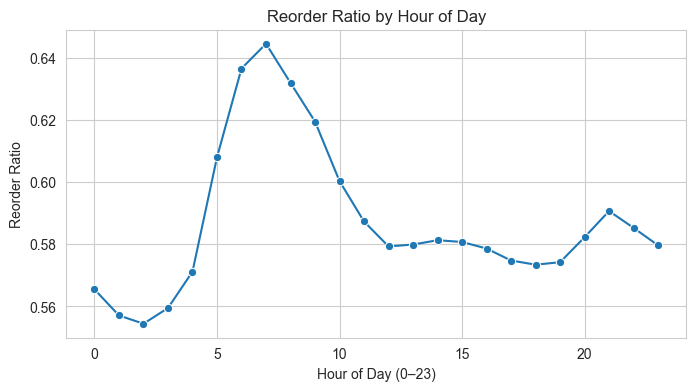

In [27]:
# Merge reorder flag with order hour info
order_products_merged = order_products.merge(
    orders[['order_id', 'order_hour_of_day']], on='order_id', how='left'
)

# Compute reorder ratio by hour
reorder_by_hour = (
    order_products_merged.groupby('order_hour_of_day')['reordered']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,4))
sns.lineplot(data=reorder_by_hour, x='order_hour_of_day', y='reordered', marker='o')
plt.title("Reorder Ratio by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Reorder Ratio")
plt.show()


### 🕓 Time-of-Day Reordering Patterns
- Reorders peak at **7 AM**, when most users shop before going to work.
- Activity drops between **12 PM to 7 PM**.
- Activity is the lowest between **12 AM and 3 AM**.
- These trends suggest **time-of-day** could be a useful predictor for reorder likelihood.
